In [1]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, get_linear_schedule_with_warmup, set_seed
from datasets import load_dataset, load_metric
import torch
import numpy as np


In [2]:
dataset = load_dataset("cnn_dailymail", "3.0.0")

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Dataset cnn_dailymail downloaded and prepared to /home/is/kaifan-l/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

In [5]:
max_article_length = max(len(article) for article in dataset['train']['article'])
max_article_length

15925

In [24]:
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-large")

In [25]:
tokenizer.model_max_length

512

In [56]:
samsum = load_dataset("samsum")
max = max(len(article) for article in samsum['train']['dialogue'])

avg = np.mean([len(article) for article in samsum['train']['dialogue']])
avg, max

Found cached dataset samsum (/home/is/kaifan-l/.cache/huggingface/datasets/samsum/samsum/0.0.0/f1d7c6b7353e6de335d444e424dc002ef70d1277109031327bc9cc6af5d3d46e)


  0%|          | 0/3 [00:00<?, ?it/s]

TypeError: 'int' object is not callable

Found cached dataset cnn_dailymail (/home/is/kaifan-l/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de)


  0%|          | 0/3 [00:00<?, ?it/s]

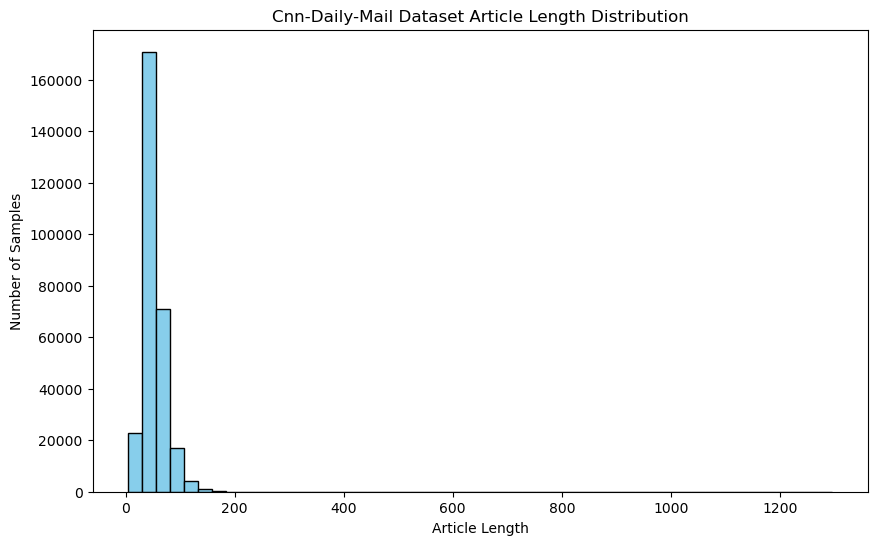

In [45]:
import matplotlib.pyplot as plt
from datasets import load_dataset

# 加载Samsum数据集
dataset = load_dataset("cnn_dailymail", "3.0.0")

# 获取文章长度信息
article_lengths = [len(article.split()) for article in dataset["train"]["highlights"]]

# 绘制文章长度分布图
plt.figure(figsize=(10, 6))
plt.hist(article_lengths, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Article Length')
plt.ylabel('Number of Samples')
plt.title('Cnn-Daily-Mail Dataset Article Length Distribution')
plt.show()

In [54]:
dataset['train']['highlights'][0]
max_l = max(len(article.split()) for article in dataset['train']['highlights'])

TypeError: 'int' object is not callable

Found cached dataset billsum (/home/is/kaifan-l/.cache/huggingface/datasets/billsum/default/3.0.0/75cf1719d38d6553aa0e0714c393c74579b083ae6e164b2543684e3e92e0c4cc)


  0%|          | 0/3 [00:00<?, ?it/s]

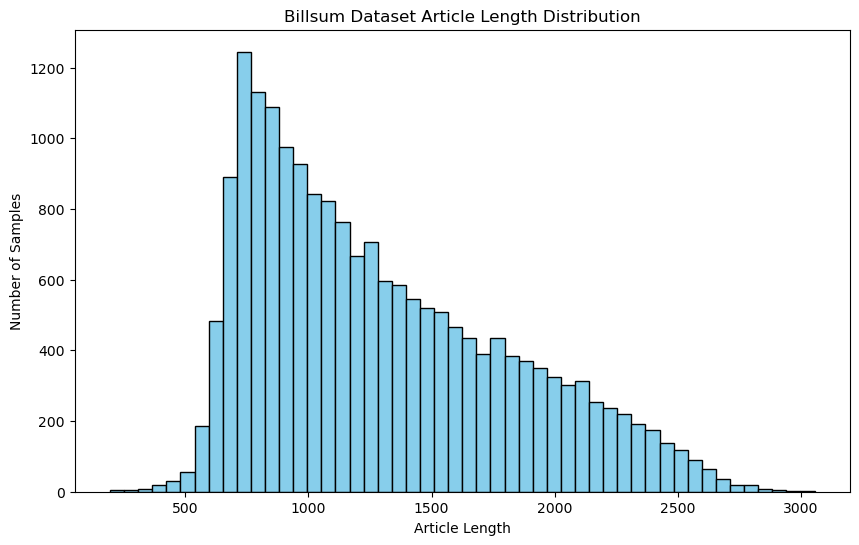

In [28]:
import matplotlib.pyplot as plt
from datasets import load_dataset

# 加载Samsum数据集
dataset = load_dataset("billsum")

# 获取文章长度信息
article_lengths = [len(article.split()) for article in dataset["train"]["text"]]

# 绘制文章长度分布图
plt.figure(figsize=(10, 6))
plt.hist(article_lengths, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Article Length')
plt.ylabel('Number of Samples')
plt.title('Billsum Dataset Article Length Distribution')
plt.show()

Found cached dataset samsum (/home/is/kaifan-l/.cache/huggingface/datasets/samsum/samsum/0.0.0/f1d7c6b7353e6de335d444e424dc002ef70d1277109031327bc9cc6af5d3d46e)


  0%|          | 0/3 [00:00<?, ?it/s]

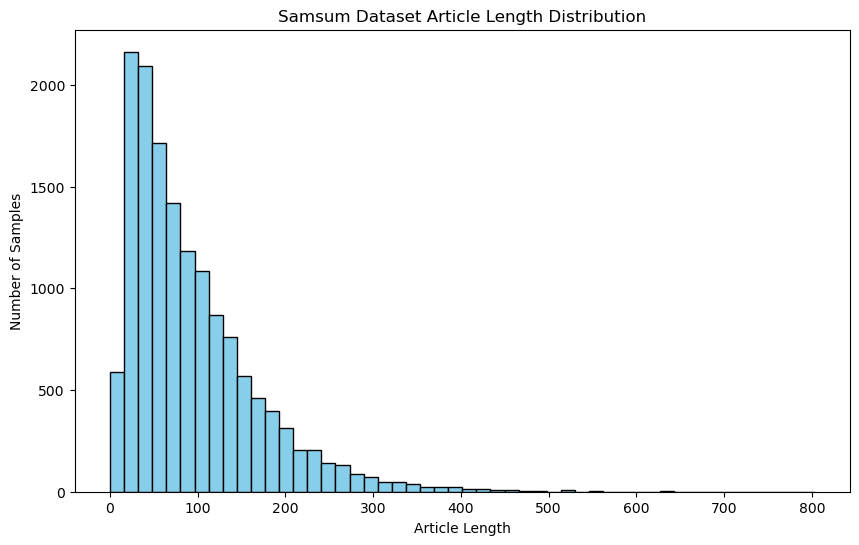

In [32]:
import matplotlib.pyplot as plt
from datasets import load_dataset

# 加载Samsum数据集
dataset = load_dataset("samsum")

# 获取文章长度信息
article_lengths = [len(article.split()) for article in dataset["train"]["dialogue"]]

# 绘制文章长度分布图
plt.figure(figsize=(10, 6))
plt.hist(article_lengths, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Article Length')
plt.ylabel('Number of Samples')
plt.title('Samsum Dataset Article Length Distribution')
plt.show()


In [60]:
model = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large-cnn")

In [61]:
model.config


BartConfig {
  "_name_or_path": "facebook/bart-large-cnn",
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_final_layer_norm": false,
  "architectures": [
    "BartForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 12,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 12,
  "eos_token_id": 2,
  "force_bos_token_to_be_generated": true,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "gradient_checkpointing": false,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "init_std": 0.02,
  "is_encoder_decoder": true,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "L

In [40]:
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large")

In [41]:
tokenizer.max_model_input_sizes

{'facebook/bart-base': 1024,
 'facebook/bart-large': 1024,
 'facebook/bart-large-mnli': 1024,
 'facebook/bart-large-cnn': 1024,
 'facebook/bart-large-xsum': 1024,
 'yjernite/bart_eli5': 1024}

In [ ]:
bart_tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large")
target_max_length = max([len(bart_tokenizer(x, truncation=True, padding='max_length')['input_ids']) for x in dataset['train']['highlights']])
print(target_max_length)

In [62]:
cnn_dataset = load_dataset("cnn_dailymail", "3.0.0")
cnn_dataset

Found cached dataset cnn_dailymail (/home/is/kaifan-l/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})